<a href="https://colab.research.google.com/github/namduhus/DenseNet/blob/master/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import os
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
from DenseNet import DenseNet, densenet121,densenet169,densenet201,densenet264

In [6]:
model = densenet264(num_classes=100)  # DenseNet-121 생성
print(model)

DenseNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (features): ModuleList(
    (0): DenseBlock(
      (layers): ModuleList(
        (0): BottleneckLayer(
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (1): BottleneckLayer(
          (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv1): Conv2d(96, 128, kernel_size=(1, 1), st

In [7]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
       BatchNorm2d-5           [-1, 64, 56, 56]             128
            Conv2d-6          [-1, 128, 56, 56]           8,192
       BatchNorm2d-7          [-1, 128, 56, 56]             256
            Conv2d-8           [-1, 32, 56, 56]          36,864
   BottleneckLayer-9           [-1, 96, 56, 56]               0
      BatchNorm2d-10           [-1, 96, 56, 56]             192
           Conv2d-11          [-1, 128, 56, 56]          12,288
      BatchNorm2d-12          [-1, 128, 56, 56]             256
           Conv2d-13           [-1, 32, 56, 56]          36,864
  BottleneckLayer-14          [-1, 128,

# 학습

In [2]:
# 1. 데이터셋 준비
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [3]:
trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

100%|██████████| 169M/169M [00:03<00:00, 43.4MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
# 2. GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [7]:
# 3. 모델 생성 및 초기화
model = densenet169(num_classes=100).to(device)

In [8]:
# 4. 손실 함수 및 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [9]:
# 5. 학습 함수
def train_model(model, trainloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in trainloader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_loss = running_loss / len(trainloader)
    train_accuracy = 100. * correct / total
    return train_loss, train_accuracy

# 6. 테스트 함수
def test_model(model, testloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    test_loss = running_loss / len(testloader)
    test_accuracy = 100. * correct / total
    return test_loss, test_accuracy

In [10]:
# 7. 학습 및 평가
num_epochs = 100

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_accuracy = train_model(model, trainloader, criterion, optimizer, device)
    test_loss, test_accuracy = test_model(model, testloader, criterion, device)
    scheduler.step()

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Epoch 1/100
Train Loss: 4.6405, Train Accuracy: 5.11%
Test Loss: 4.1443, Test Accuracy: 7.93%
Epoch 2/100
Train Loss: 3.7920, Train Accuracy: 10.66%
Test Loss: 4.0692, Test Accuracy: 13.03%
Epoch 3/100
Train Loss: 3.5502, Train Accuracy: 14.48%
Test Loss: 3.3980, Test Accuracy: 17.48%
Epoch 4/100
Train Loss: 3.2795, Train Accuracy: 19.40%
Test Loss: 3.1840, Test Accuracy: 22.22%
Epoch 5/100
Train Loss: 3.0615, Train Accuracy: 23.52%
Test Loss: 2.9722, Test Accuracy: 25.87%
Epoch 6/100
Train Loss: 2.8899, Train Accuracy: 26.92%
Test Loss: 2.8016, Test Accuracy: 28.88%
Epoch 7/100
Train Loss: 2.7038, Train Accuracy: 30.35%
Test Loss: 2.6687, Test Accuracy: 31.80%
Epoch 8/100
Train Loss: 2.5143, Train Accuracy: 34.21%
Test Loss: 2.5201, Test Accuracy: 35.28%
Epoch 9/100
Train Loss: 2.3962, Train Accuracy: 36.65%
Test Loss: 2.3638, Test Accuracy: 38.34%
Epoch 10/100
Train Loss: 2.2641, Train Accuracy: 39.55%
Test Loss: 2.3625, Test Accuracy: 38.59%
Epoch 11/100
Train Loss: 2.1583, Train Ac

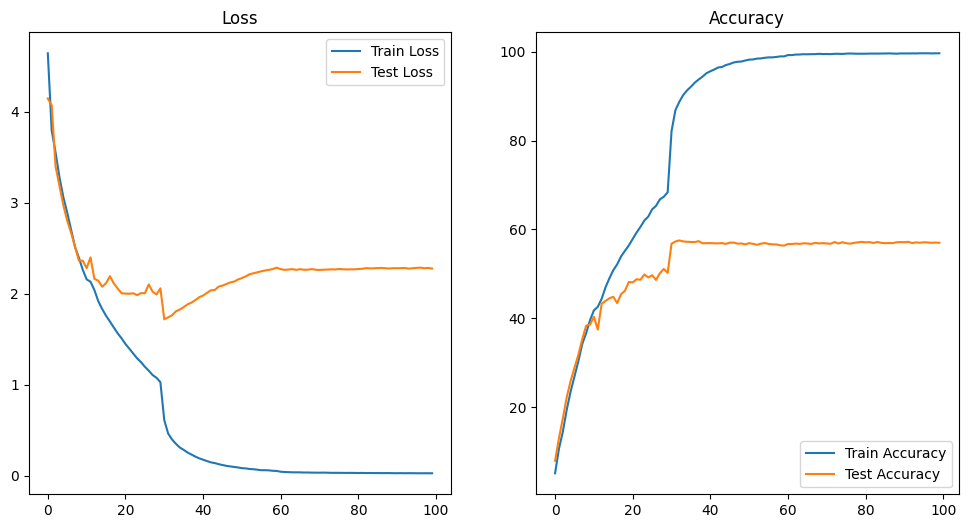

In [11]:
# 8. 학습 결과 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()